In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, t, binom, gamma
from scipy.optimize import minimize

## Question 1 (Importance Sampling for Rare Event Probability)

* (a) For $a=2, 4, 6$, calculate $P(X>a)=\int_a^\infty\phi(x)\mathrm{d} x$, where $X\sim N(0, 1)$. With 100000 samples, use the `Naive' approach (simulate samples from $\phi(x)$), the non-ratio version Importance Sampling (simulate samples from $q(x)=e^{-(x-a)}\mathbf{1}_{[a,\infty)}(x)$) or the ratio version Importance Sampling (simulate samples from $q(x)=0.5t_4(x)+0.5e^{-(x-a)}\mathbf{1}_{[a,\infty)}(x)$) to calculate the point estimates and the confidence intervals. 

In [2]:
def estimate(a, n):
    truth = norm.cdf(-a)
    print('truth: {:.4e}'.format(truth))
    
    samples1 = norm.rvs(size=n)
    w_x_f_1 = samples1 > a
    est_Naive = np.mean(w_x_f_1)
    err_Naive = np.abs(est_Naive - truth)
    var_Naive = np.var(w_x_f_1) / n
    print('est(Naive): {:.4e}; err: {:.4e}'
          .format(est_Naive, err_Naive))
    print('C.I.(Naive): [{:.4e}, {:.4e}]'
          .format(est_Naive - 1.96*np.sqrt(var_Naive), est_Naive + 1.96*np.sqrt(var_Naive)))
    
    samples2 = expon(loc=a).rvs(size=n)
    w_x_f_2 = (samples2 > a) * norm.pdf(samples2) / expon(loc=a).pdf(samples2)
    est_nrvIS = np.mean(w_x_f_2)
    err_nrvIS = np.abs(est_nrvIS - truth)
    var_nrvIS = np.var(w_x_f_2) / n
    print('est(nrvIS): {:.4e}; err: {:.4e}'
          .format(est_nrvIS, err_nrvIS))
    print('C.I.(nrvIS): [{:.4e}, {:.4e}]'
          .format(est_nrvIS - 1.96*np.sqrt(var_nrvIS), est_nrvIS + 1.96*np.sqrt(var_nrvIS)))
    
    n1 = binom(n=n, p=0.5).rvs()
    samples3 = np.append(t(df=4).rvs(size=n1), expon(loc=a).rvs(size=n - n1))
    weights3 = norm.pdf(samples3) / (0.5*t(df=4).pdf(samples3) + 0.5*expon(loc=a).pdf(samples3))
    w_x_f_3 = (samples3 > a) * weights3
    est_rvIS = np.mean(w_x_f_3) / np.mean(weights3)
    err_rvIS = np.abs(est_rvIS - truth)
    var_rvIS = np.mean((w_x_f_3 - est_rvIS * weights3)**2) / n
    print('est(rvIS): {:.4e}; err: {:.4e}'
          .format(est_rvIS, err_rvIS))
    print('C.I.(rvIS): [{:.4e}, {:.4e}]'
          .format(est_rvIS - 1.96*np.sqrt(var_rvIS), est_rvIS + 1.96*np.sqrt(var_rvIS)))

In [3]:
np.random.seed(19971107)
estimate(2, 100000)
estimate(4, 100000)
estimate(6, 100000)

truth: 2.2750e-02
est(Naive): 2.2790e-02; err: 3.9868e-05
C.I.(Naive): [2.1865e-02, 2.3715e-02]
est(nrvIS): 2.2732e-02; err: 1.7752e-05
C.I.(nrvIS): [2.2623e-02, 2.2842e-02]
est(rvIS): 2.2611e-02; err: 1.3951e-04
C.I.(rvIS): [2.2297e-02, 2.2924e-02]
truth: 3.1671e-05
est(Naive): 1.0000e-05; err: 2.1671e-05
C.I.(Naive): [-9.5999e-06, 2.9600e-05]
est(nrvIS): 3.1379e-05; err: 2.9272e-07
C.I.(nrvIS): [3.1142e-05, 3.1615e-05]
est(rvIS): 3.1761e-05; err: 8.9667e-08
C.I.(rvIS): [3.1240e-05, 3.2282e-05]
truth: 9.8659e-10
est(Naive): 0.0000e+00; err: 9.8659e-10
C.I.(Naive): [0.0000e+00, 0.0000e+00]
est(nrvIS): 9.8958e-10; err: 2.9961e-12
C.I.(nrvIS): [9.8009e-10, 9.9907e-10]
est(rvIS): 9.7506e-10; err: 1.1526e-11
C.I.(rvIS): [9.5695e-10, 9.9317e-10]


* (b) Calculate the optimal proposals of both non-ratio or ratio version Importance Sampling. Compare the IS proposals in (a) with the corresponding optimal proposals by plots. 

In [4]:
def compare(a):
    truth = norm.cdf(-a)
    opt_nrvIS = lambda x: (x > a) * norm.pdf(x) / truth
    opt_rvIS = lambda x: norm.pdf(x) * np.abs((x > a) - truth) / (2 * truth * (1 - truth))
    proposal_nrvIS = expon(loc=a).pdf
    proposal_rvIS = lambda x: 0.5*t(df=4).pdf(x) + 0.5*expon(loc=a).pdf(x)
    
    fig, axs = plt.subplots(1,2,figsize=[15, 5])
    x = np.linspace(a-1, a+5, 1000)
    axs[0].plot(x, opt_nrvIS(x), label='non-ratio IS optimal proposal')
    axs[0].plot(x, proposal_nrvIS(x), label='non-ratio IS proposal')
    axs[0].legend()
    
    x = np.linspace(-4, a+5, 1000)
    axs[1].plot(x, opt_rvIS(x), label='ratio IS optimal proposal')
    axs[1].plot(x, proposal_rvIS(x), label='ratio IS proposal')
    axs[1].legend()
    plt.show()

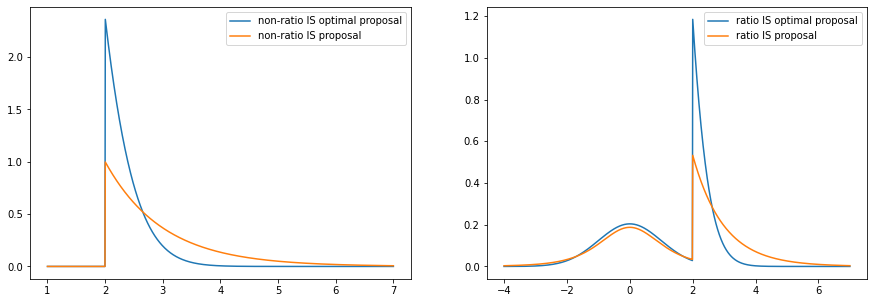

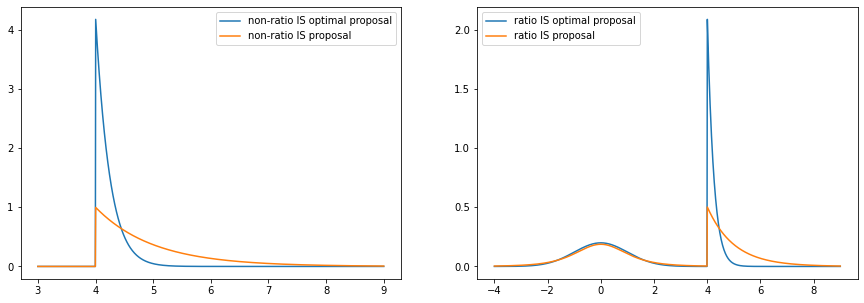

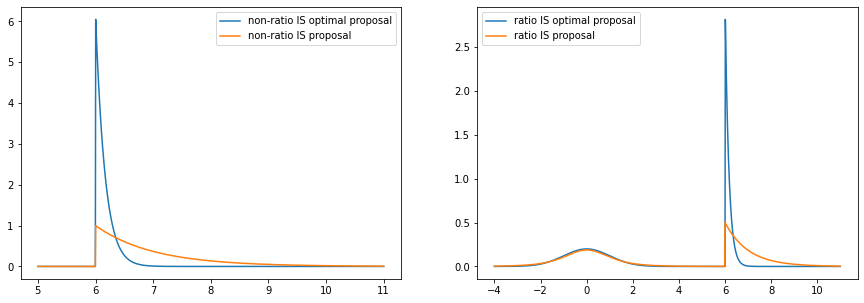

In [5]:
compare(2)
compare(4)
compare(6)

* (c) For the non-ratio version IS, we find that the previous IS proposal too flat compared to the optimal proposal. To improve the performance of Importance Sampling, we assume the proposal family $q(x|b)=be^{-b(x-a)}\mathbf{1}_{[a,\infty)}(x)$. To find the best parameter $b$, notice that the asymptotic variance can be estimated by
$$\begin{align*}
\sigma^2(b)&=\mathbb{E}_b[(w_b(X)f(X)-\mu)^2]=\int\frac{(\phi(x)\mathbf{1}_{[a,\infty)}(x)-\mu q(x|b))^2}{q(x|b)}\mathrm{d}x=\int\frac{(\phi(x)\mathbf{1}_{[a,\infty)}(x))^2}{q(x|b)}\mathrm{d}x-\mu^2\\
&\approx\hat{S}(b|b_0)-\mu^2=\frac{1}{n}\sum_{i=1}^n\frac{(\phi(x_i)\mathbf{1}_{[a,\infty)}(x_i))^2}{q(x_i|b)q(x_i|b_0)}-\mu^2, x_i\sim q(x|b_0), i=1,\dots,n. 
\end{align*}$$
So, instead of minimizing $\sigma^2(b)$ with respect to $b$, we can minimize $\hat{S}(b|b_0)$ for a given $b_0$. Further more, we can even do the optimization iteratively (replace $b_0$ by the optimal $b$), which lead to the Adaptive Importance Sampling (AIS) methodology. When $a=6$, $b_0=1$ and $n=100$, build the AIS algorithm and find the optimal $b$, draw the log value of asymptotic variance (estimated with 100000 new samples) corresponding to the initial and optimal $b$'s against iteration numbers. When does this algorithm converge? 

In [6]:
def estimate(a, b, n):
    samples = expon(loc=a, scale=1 / b).rvs(size=n)
    return np.var((samples > a) * norm.pdf(samples) / expon(loc=a, scale=1 / b).pdf(samples))

def iterate(a, b0, n):
    samples = expon(loc=a, scale=1 / b0).rvs(size=n)
    S_hat = lambda b: np.mean(((samples > a) * norm.pdf(samples))**2 / 
                              (expon(loc=a, scale=1 / b).pdf(samples) * expon(loc=a, scale=1 / b0).pdf(samples)))
    return minimize(lambda b: np.log(S_hat(b)), x0=b0, tol=1e-10).x[0]

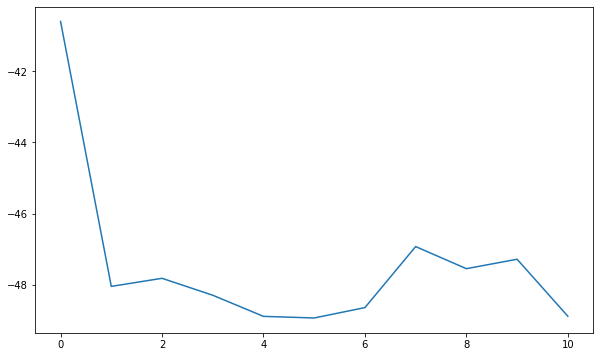

In [7]:
np.random.seed(19971107)
a = 6
b0 = 1
n = 100
bs = [b0]
avar = [estimate(a, b0, 100000)]
K = 10
for k in range(K):
    b_new = iterate(a, bs[-1], n)
    bs.append(b_new)
    avar.append(estimate(a, b_new, 100000))
    
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(np.arange(K + 1), np.log(avar))
plt.show()

* (d) In many cases, instead of simple $P(X>a)$, we are more interested in estimating $P(h(X)>a)$ for a function $h(x)$ and a large $a$, which can be really complicated especially when it is a multidimensional problem. For illustration, we return to the original problem of the estimation for $P(X>a)$, $X\sim N(0, 1)$, but this time we consider the gamma family $q(x|b,c)=b^2(x-c)e^{-b(x-c)}\mathbf{1}_{[c,\infty)}(x)$ and try to obtain the optimal values for $b$ and $c$ automatically. So, consider
$$
\hat{S}(b,c|b_0,c_0)=\frac{1}{n}\sum_{i=1}^n\frac{(\phi(x_i)\mathbf{1}_{[a^*,\infty)}(x_i))^2}{q(x_i|b,c)q(x_i|b_0,c_0)}, x_i\sim q(x|b_0,c_0), i=1,\dots,n
$$
where $a^*=\min(a, a^{(1-\varepsilon)})$, $a^{(1-\varepsilon)}$ is the $(1-\varepsilon)$-quantile of $\{x_i\}$. When $a=6$, $b_0=1$, $c_0=0$, $n=100$ and $\varepsilon=0.1$, build an AIS algorithm to find the optimal $b$ and $c$, draw the log value of asymptotic variance (estimated with enough new samples) corresponding to the initial and optimal parameters against iteration numbers. When does this algorithm converge? The spirit behind this algorithm actually coincide with that of the Generative Adversarial Networks, think about why (no need to answer this). 

In [8]:
def estimate(a, b, c, n):
    samples = gamma(a=2, loc=c, scale=1 / b).rvs(size=n)
    return np.var((samples > a) * norm.pdf(samples) / gamma(a=2, loc=c, scale=1 / b).pdf(samples))

def iterate(a, b0, c0, n, eps):
    samples = gamma(a=2, loc=c0, scale=1 / b0).rvs(size=n)
    a0 = min(a, np.quantile(samples, 1 - eps))
    def S_hat(pars):
        nom = ((samples > a0) * norm.pdf(samples))**2 
        den = gamma(a=2, loc=pars[1], scale=1 / pars[0]).pdf(samples) * gamma(a=2, loc=c0, scale=1 / b0).pdf(samples)
        den[den == 0] = 1e-100
        return np.mean(nom / den)
    
    return minimize(lambda pars: np.log(S_hat(pars)), x0=[b0, c0], tol=1e-10).x

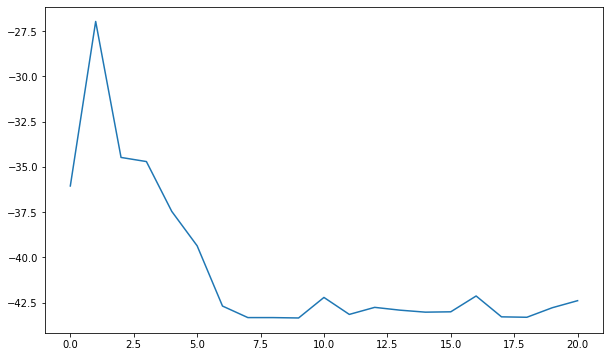

In [9]:
np.random.seed(19971107)
a = 6
b0 = 1
c0 = 0
n = 100
bs = [b0]
cs = [c0]
eps = 0.1
avar = [estimate(a, b0, c0, 2000000)]
K = 20
for k in range(K):
    b_new, c_new = iterate(a, bs[-1], cs[-1], n, eps)
    bs.append(b_new)
    cs.append(c_new)
    avar.append(estimate(a, b_new, c_new, 2000000))
    
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(np.arange(K + 1), np.log(avar))
plt.show()